In [7]:
from bs4 import BeautifulSoup
import csv
import time
import requests
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [ ]:
journal_selection = "all"
max_pages = 1000

## Scraping

In [8]:
def get_soup(url):
    """
    Extract page as html using BeautifulSoup.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    return soup

In [9]:
def make_url(page):
    # url = f"https://link.springer.com/search/page/{page}?query=depression&facet-discipline=%22Psychology%22&facet-start-year=2018&facet-language=%22En%22&sortOrder=newestFirst&query=depression&facet-end-year=2024&facet-content-type=%22Article%22"
    url = f"https://link.springer.com/search/page/{page}?date-facet-mode=between&facet-discipline=%22Psychology%22&facet-start-year=2018&facet-language=%22En%22&sortOrder=newestFirst&facet-end-year=2023&facet-content-type=%22Article%22"
    # url = f"https://link.springer.com/search/page/{page}?facet-end-year=2023&date-facet-mode=between&previous-end-year=2023&sortOrder=newestFirst&query=depression&previous-start-year=1832&facet-start-year=2019&facet-content-type=%22Article%22"
    return url

In [10]:
allowed_journals = ["European Archives of Psychiatry and Clinical Neuroscience"]

In [11]:
# store results for multiple pages
hrefs_results = []

for page in tqdm(range(0, 100)):

    # get page results
    url = make_url(page)
    soup = get_soup(url)
    # print(soup)

    # get all citations and extract links to article
    journals = soup.find_all('a', {'class': "publication-title"})
    for journal in journals:
        # if journal["title"] in allowed_journals:
        #     print("JA")
        citations = soup.find_all('a', {'class': 'title'}, href=True)
        hrefs = [citation["href"] for citation in citations]
        hrefs_results += hrefs

    # extract text and remove tag
    # citations = [citation.get_text() for citation in citations]
    
    # keep only journals of interest
    # citations = [citation for citation in citations if citation.split('.')[0] in journals]
    # results += citations
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
hrefs_results

['/article/10.1007/s10964-022-01720-3',
 '/article/10.1007/s10964-022-01725-y',
 '/article/10.1007/s10964-023-01759-w',
 '/article/10.1007/s10964-023-01761-2',
 '/article/10.1007/s10964-022-01732-z',
 '/article/10.1007/s10964-022-01723-0',
 '/article/10.1007/s10964-022-01721-2',
 '/article/10.1007/s10964-022-01726-x',
 '/article/10.1007/s10964-023-01750-5',
 '/article/10.1007/s10964-022-01731-0',
 '/article/10.1007/s10964-023-01734-5',
 '/article/10.1007/s10964-023-01760-3',
 '/article/10.1007/s10964-022-01722-1',
 '/article/10.1007/s10964-022-01727-w',
 '/article/10.1007/s10964-020-01375-y',
 '/article/10.1007/s10869-022-09849-5',
 '/article/10.1007/s10964-023-01735-4',
 '/article/10.1007/s00426-022-01693-9',
 '/article/10.1007/s11031-022-09983-w',
 '/article/10.3758/s13421-022-01281-7',
 '/article/10.1007/s10964-022-01720-3',
 '/article/10.1007/s10964-022-01725-y',
 '/article/10.1007/s10964-023-01759-w',
 '/article/10.1007/s10964-023-01761-2',
 '/article/10.1007/s10964-022-01732-z',


In [13]:
springer_url = "https://link.springer.com"

all_dates = {"Received": [], "Accepted": [], "Published": []}
print()

for href in tqdm(hrefs_results):
    url = springer_url + href
    soup = get_soup(url)
    dates = soup.find_all('ul', {'class': 'c-bibliographic-information__list'})

    for date in dates:
        subsoup = date.findAll('p')
        # print(len(subsoup))
        for i, soup in enumerate(subsoup):

            # first item is accepted
            for date_type in ["Received", "Published", "Accepted"]:
                if date_type in soup.get_text():
                    day = soup.find('time')
                    day = day["datetime"]
                    all_dates[date_type].append(day)

  0%|          | 0/40000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Data formatting

In [ ]:
df_received = pd.DataFrame(all_dates["Received"], columns=["Received"])
df_received["Received"] = pd.to_datetime(df_received["Received"])
df_received.head()

,Received
0,2022-11-19
1,2022-10-07
2,2022-12-03
3,2022-04-16
4,2022-04-12


In [ ]:
df_accepted = pd.DataFrame(all_dates["Accepted"], columns=["Accepted"])
df_accepted["Accepted"] = pd.to_datetime(df_accepted["Accepted"])
df_accepted.head()

,Accepted
0,2021-03-03
1,2022-12-09
2,2022-12-07
3,2022-12-07
4,2022-06-06


In [ ]:
df_received.shape, df_accepted.shape

((2786, 1), (3872, 1))

In [ ]:
df_received.to_csv(f"df_received_{max_pages}_{journal_selection}.csv", index=False)
df_accepted.to_csv(f"df_accepted_{max_pages}_{journal_selection}.csv", index=False)

## Plotting

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

def smooth_plot(data, color, label):
    
    #create data
    x = np.arange(0, 12, 1)
    x_ticks = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    y = np.array(data)

    #define x as 200 equally spaced values between the min and max of original x 
    xnew = np.linspace(x.min(), x.max(), 200) 

    #define spline with degree k=7
    spl = make_interp_spline(x, y, k=7)
    y_smooth = spl(xnew)

    #create smooth line chart 
    plt.plot(xnew, y_smooth, color=color, label=label)

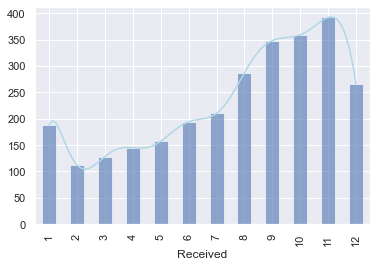

In [ ]:
df_received.groupby(df_received["Received"].dt.month).count().plot(kind="bar", alpha=0.6, legend=False)
smooth_plot(df_received.groupby(df_received["Received"].dt.month).count(), "lightblue", "Received")

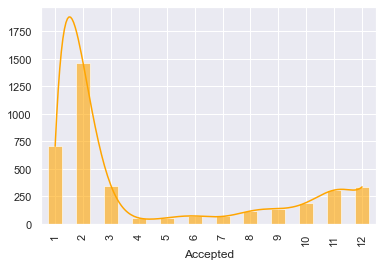

In [ ]:
df_accepted.groupby(df_accepted["Accepted"].dt.month).count().plot(kind="bar", alpha=0.6, color="orange", legend=False)
smooth_plot(df_accepted.groupby(df_accepted["Accepted"].dt.month).count(), "orange", "Accepted")

Text(0, 0.5, 'Count')

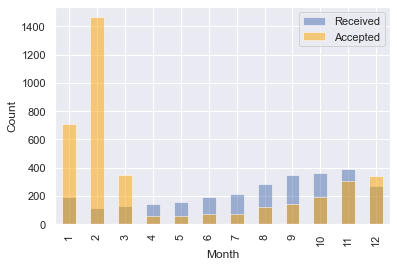

In [ ]:
ax = df_received.groupby(df_received["Received"].dt.month).count().plot(kind="bar", alpha=0.5)
df_accepted.groupby(df_accepted["Accepted"].dt.month).count().plot(kind="bar", color="orange", alpha=0.5, ax=ax)
plt.xlabel("Month")
plt.ylabel("Count")

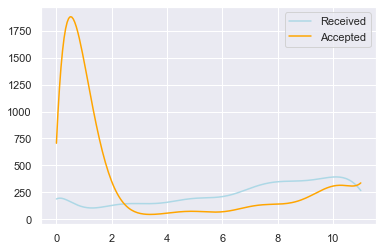

In [ ]:
smooth_plot(df_received.groupby(df_received["Received"].dt.month).count(), "blue", "Received")
smooth_plot(df_accepted.groupby(df_accepted["Accepted"].dt.month).count(), "orange", "Accepted")
plt.legend()

Text(0.5, 0, 'Count')

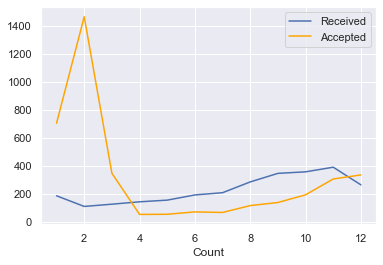

In [ ]:
ax = df_received.groupby(df_received["Received"].dt.month).count().plot(kind="line")
df_accepted.groupby(df_accepted["Accepted"].dt.month).count().plot(kind="line", color="orange", ax=ax)
plt.xlabel("Month")
plt.xlabel("Count")